In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
nltk.download('punkt')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score



[nltk_data] Downloading package punkt to C:\Users\MITALI
[nltk_data]     VERMA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
col_names = ['ID', 'Entity', 'Sentiment', 'Content']
df = pd.read_csv('twitter_training.csv', names=col_names)
df.head()

,ID,Entity,Sentiment,Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Entity     74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [10]:
df.dtypes

ID            int64
Entity       object
Sentiment    object
Content      object
dtype: object

In [11]:
df.isnull().sum()

ID             0
Entity         0
Sentiment      0
Content      686
dtype: int64

In [12]:
df.dropna(subset = ['Content'],inplace=True)
total_duplicates = df[df.duplicated(keep='first')].shape[0]
print("Total duplicate rows:", total_duplicates)

Total duplicate rows: 2340


In [13]:
df.drop_duplicates(keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

replace irrelevant to neutral

In [12]:
df['Sentiment'] = df['Sentiment'].replace('Irrelevant', 'Neutral')

## Exploratory Data Analysis

In [14]:
df.Sentiment.unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

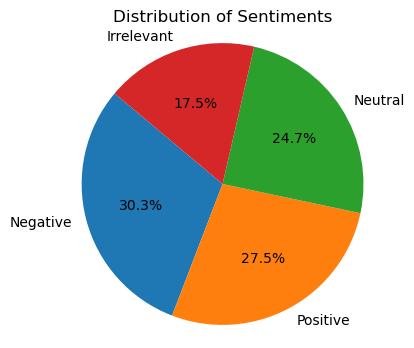

In [15]:
sentiment_distribution = df['Sentiment'].value_counts()
plt.figure(figsize=(4, 4))
plt.pie(sentiment_distribution, labels=sentiment_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiments')
plt.axis('equal') 
plt.show()

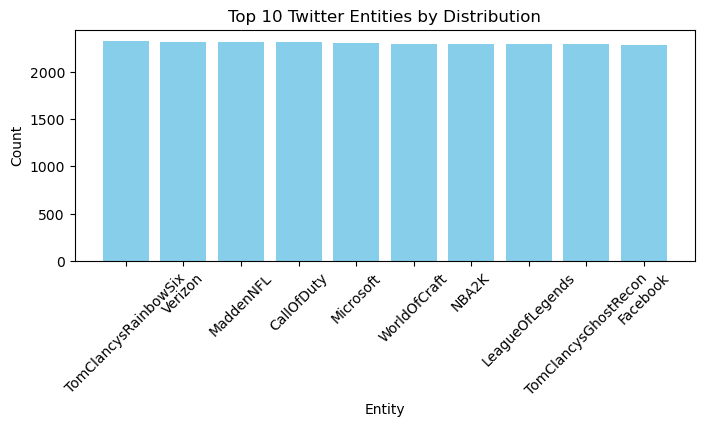

In [16]:
entity_distribution = df['Entity'].value_counts()
top_10_entities = entity_distribution.head(10)
plt.figure(figsize=(8, 3))
plt.bar(top_10_entities.index, top_10_entities.values, color='skyblue')
plt.title('Top 10 Twitter Entities by Distribution')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

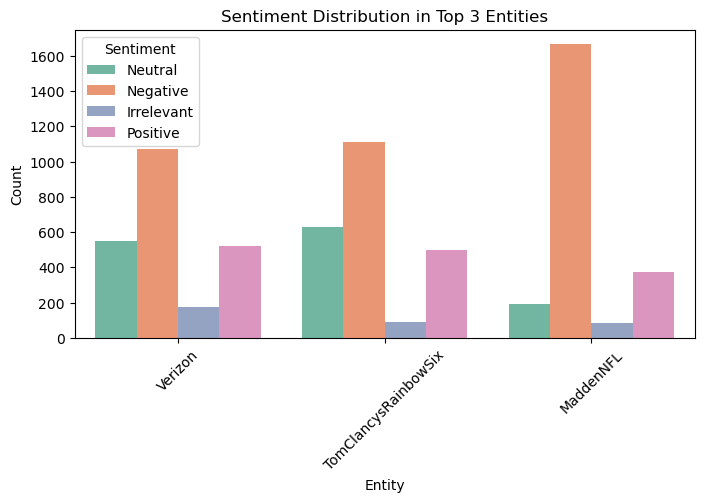

In [17]:
entity_distribution = df['Entity'].value_counts()
top_3_entities = entity_distribution.head(3).index
df_top_3 = df[df['Entity'].isin(top_3_entities)]
plt.figure(figsize=(8, 4))
sns.countplot(data=df_top_3, x='Entity', hue='Sentiment', palette='Set2')
plt.title('Sentiment Distribution in Top 3 Entities')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

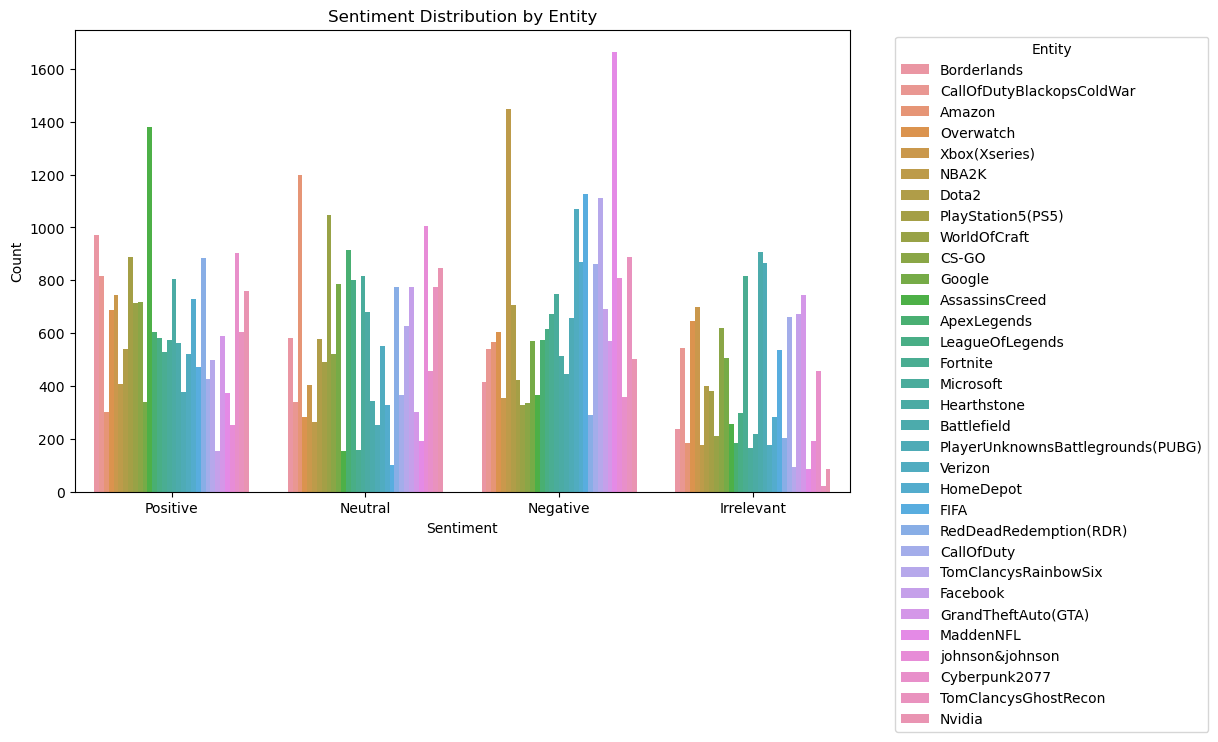

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Sentiment', hue='Entity')
plt.title("Sentiment Distribution by Entity")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.legend(title='Entity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Text Analysis with NLP Preprocessing

In [19]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()  
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens] 
    tokens = [word for word in tokens if word not in stop_words]  
    return ' '.join(tokens)

df['Cleaned_Content'] = df['Content'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to C:\Users\MITALI
[nltk_data]     VERMA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\MITALI
[nltk_data]     VERMA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\MITALI
[nltk_data]     VERMA\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [20]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

df['Sentiment_Score'] = df['Cleaned_Content'].apply(get_sentiment_scores)

def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment_Predicted'] = df['Sentiment_Score'].apply(categorize_sentiment)


[nltk_data] Downloading package vader_lexicon to C:\Users\MITALI
[nltk_data]     VERMA\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


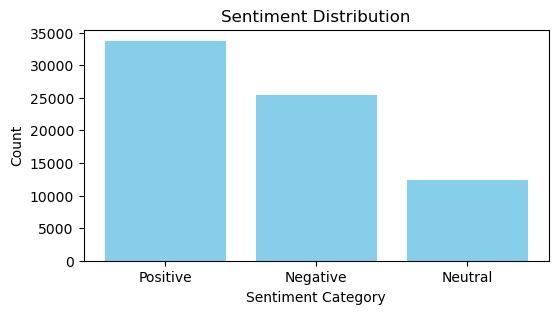

In [21]:
sentiment_distribution = df['Sentiment_Predicted'].value_counts()
plt.figure(figsize=(6, 3))
plt.bar(sentiment_distribution.index, sentiment_distribution.values, color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

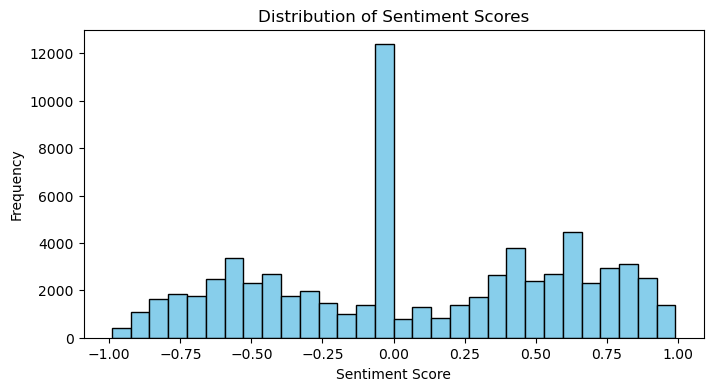

In [22]:
plt.figure(figsize=(8, 4))
plt.hist(df['Sentiment_Score'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

## Text Data Analysis

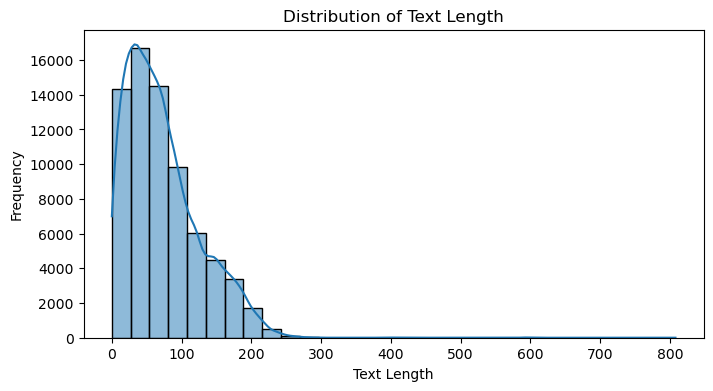

In [23]:
df['Text_Length'] = df['Cleaned_Content'].str.len() 
plt.figure(figsize=(8, 4))
sns.histplot(df['Text_Length'], bins=30, kde=True)
plt.title("Distribution of Text Length")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

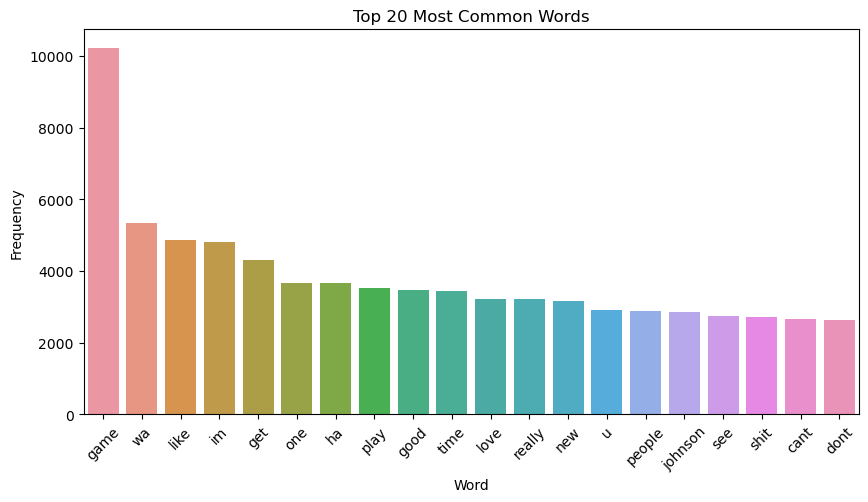

In [24]:
from collections import Counter
words = ' '.join(df['Cleaned_Content']).split()
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)
plt.figure(figsize=(10, 5))
sns.barplot(x=[word[0] for word in most_common_words], y=[word[1] for word in most_common_words])
plt.title("Top 20 Most Common Words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


#### Word Cloud for Positive Sentiment

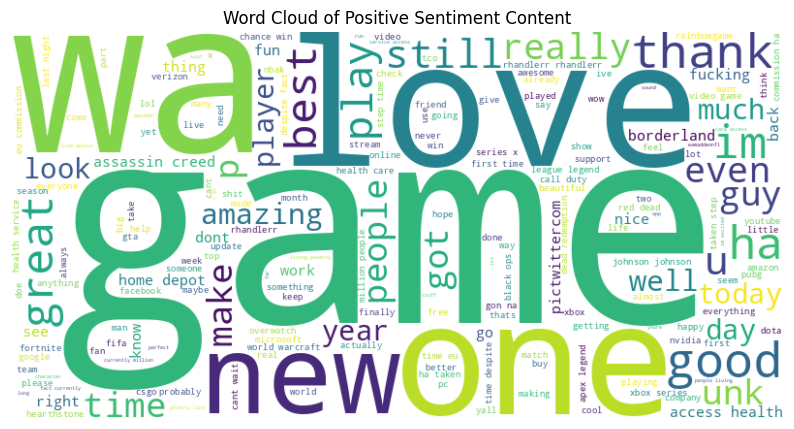

In [25]:
positive_data = df[df['Sentiment_Predicted'] == 'Positive']
positive_text_data = ' '.join(positive_data['Cleaned_Content'].dropna())
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text_data)
plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Positive Sentiment Content")
plt.show()

## MODELING

In [28]:
X = df['Cleaned_Content'] 
y = df['Sentiment_Predicted'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [30]:
model = LogisticRegression(max_iter=1000, solver='saga')
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000, solver='saga')

In [31]:
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9066424783700809
              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90      5066
     Neutral       0.89      0.85      0.87      2471
    Positive       0.92      0.93      0.93      6795

    accuracy                           0.91     14332
   macro avg       0.90      0.89      0.90     14332
weighted avg       0.91      0.91      0.91     14332

